In [1]:
# imports
import pandas as pd
from collections import Counter
import json
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

In [2]:
# read in the data and convert to json
df_art = pd.read_csv('clean_articles.csv')
df_art.word_counts = df_art.word_counts.apply(lambda x: x[8:-1].replace("'", "\""))
df_art.word_counts = df_art.word_counts.apply(json.loads)
df_art.head()

,title,subreddit,word_counts
0,Meta's threat to close down Facebook and Insta...,nottheonion,"{'data': 14, 'transfer': 7, 'european': 6, 'wi..."
1,Pregnant Texas woman driving in HOV lane told ...,nottheonion,"{'said': 7, 'officer': 6, 'according': 5, 'cit..."
2,Mark Zuckerberg Says Meta Employees “Lovingly”...,nottheonion,"{'given': 2, 'employee': 2, 'energy': 2, 'news..."
3,Police didn't immediately confront the gunman ...,nottheonion,"{'school': 5, 'shooting': 5, 'gunman': 5, 'off..."
4,Shaquille O'Neal says gorillas freak out when ...,nottheonion,"{'gorilla': 9, 'zoo': 5, 'look': 5, 'story': 4..."


In [3]:
# turn the word counts into individual column counts
df_word_cols = pd.json_normalize(df_art['word_counts'])
df_word_cols.head()

,data,transfer,european,without,service,would,server,company,leader,good,...,microeconomy,timetravel,carload,visiblesomething,fooled,hotoshop,spotthedifference,photoshops,hotoshopped,rightsideup
0,14.0,7.0,6.0,5.0,5.0,4.0,4.0,4.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,1.0,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# KEEP the most frequent 500 words as feature columns

# add a row with the total occurences
df_word_cols.loc['total'] = df_word_cols.sum(axis=0)

# sort the columns by the row descending
df_word_cols=df_word_cols[df_word_cols.iloc[-1,:].sort_values(ascending=False).index]

# keep the first 500 columns
df_word_cols = df_word_cols.iloc[:, :500]

# drop the 'total' row
df_word_cols = df_word_cols.drop('total')
df_word_cols.tail()

,said,would,time,one,people,year,like,also,could,state,...,stand,hard,lawyer,caused,shared,thousand,husband,showed,start,happen
1555,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1557,NaN,1.0,2.0,4.0,NaN,2.0,NaN,3.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1558,1.0,3.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1559,1.0,3.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# merge the outcome column (subreddit) back into the dataframe
df_art_features = pd.merge(df_art['subreddit'], df_word_cols, left_index=True, right_index=True)

# change column, nottheonion = 0, TheOnion = 1
df_art_features.loc[df_art_features['subreddit'] == 'nottheonion', 'subreddit'] = 0
df_art_features.loc[df_art_features['subreddit'] == 'TheOnion', 'subreddit'] = 1

# fill NaN with zeros
df_art_features = df_art_features.fillna(0)

# preview data
df_art_features.head()

,subreddit,said,would,time,one,people,year,like,also,could,...,stand,hard,lawyer,caused,shared,thousand,husband,showed,start,happen
0,0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,7.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0,4.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# note - code reused from in-class lab
def confusion_matrix(y_true, y_pred):
    """ Generate a confusion matrix.
    y = actual outcomes (0, 1, 2, ...)
    y_pred = predicted outcomes (0, 1, 2, ...)
    return confusion matrix as a numpy array
    """
    
    # Find unique identifiers
    unique_classes = set(y_true) | set(y_pred)
    n_classes = len(unique_classes)
    
    # Create matrix (all zeros)
    matrix = np.zeros(shape=(n_classes, n_classes), dtype=int)
    
    # Pair up each actual outcome with the corresponding prediction
    actual_prediction = list(zip(y_true, y_pred))
    
    # For each pair, increment the correct position in the matrix
    for i,j in actual_prediction:
        i = int(float(i))
        j = int(float(j))
        matrix[i,j] += 1
        
    return matrix

In [7]:
# note - code reused from in-class lab
def metrics(y_true, y_pred, places=4):
    """ Generate accuracy scores for classifier.
    Round each score to <places> decimal places """
    
    scores = {}
    C = confusion_matrix(y_true, y_pred)
    
    scores['accuracy'] = C.diagonal().sum() / C.sum()
    
    if C.shape == (2,2):
        TN, FP, FN, TP = C.ravel() #  ravel flattens the array row by row
        # calc scores
        scores['sensitivity'] = TP / (TP + FN)
        scores['specificity'] = TN / (TN + FP)
        scores['precision'] = TP / (TP + FP)
        scores['f1_score'] = 2 * TP / (2 * TP + FP + FN)
    else:
        pass # do later
        
    return scores  

In [8]:
def predict(X, w):
    # predict outcome, 0 or 1
    bias = w[0]
    wts = w[1:]
    
    # across every row want to compute w0 + w1 x1 + w2 x2 ... (bias = w0, weights are w1...) - dot product
    x_score = bias + X.dot(wts)
    
    # if score is below line (negative) then predict 0, if score is above line (positive) then predict 1
    x_ypred = (x_score >= 0).astype(int)
    
    return x_ypred

In [9]:
def perceptron(data, alpha, epochs):
    
    # dataframes for x and the outcome
    data_x = data.iloc[:, 1:]
    data_outcome = data.iloc[:, 0]
    
    # get number of columns
    num_cols = len(data.axes[1])
    
    # start with a random list of weights betw -1 and 1
    wts = np.random.uniform(-1, 1, size=num_cols).tolist()
    
    # lists to hold info on mpe and # of correct predictions
    accuracy = []
    mpe = []
    
    for e in range(epochs):
        
        # predict outcome, 0 or 1
        bias = wts[0]
        w = wts[1:]

        # across every row want to compute w0 + w1 x1 + w2 x2 ... (bias = w0, weights are w1...) - dot product
        x_score = bias + data_x.dot(w)

        # if score is below line (negative) then predict 0, if score is above line (positive) then predict 1
        data_ypred = (x_score >= 0).astype(int)

        # difference betw y and ypred, outcome column (last column) - ypred
        diff_series = data_outcome - data_ypred

        # adjust the weights
        for c in range(num_cols):
            
            # new weight is equal to sum of alpha * (outcome - 
            if c == 0:
                wts[c] =  wts[c] + sum(alpha * diff_series)
            else:
                wts[c] = wts[c] + sum(alpha * diff_series * data_x.iloc[:, c - 1])
             
        # Accuracy
        m = metrics(data_outcome, data_ypred)
        accuracy.append(m['accuracy'])
        
        # Contribution to error
        data_error = np.abs(diff_series) * np.abs(x_score)
        mpe.append(data_error.mean())
        
    return wts, accuracy, mpe

In [10]:
# run perception function
w, acc, mpe = perceptron(data=df_art_features, alpha=0.0001, epochs=500)

In [11]:
# find metrics based on final weights from above
y_true = df_art_features['subreddit']
y_pred = predict(df_art_features.iloc[:, 1:], w)
metrics(y_true, y_pred)

{'accuracy': 0.9506410256410256,
 'sensitivity': 0.9513888888888888,
 'specificity': 0.9497126436781609,
 'precision': 0.9591598599766628,
 'f1_score': 0.9552585705984893}

[Text(0.5, 1.0, 'Accuracy vs. Epoch')]

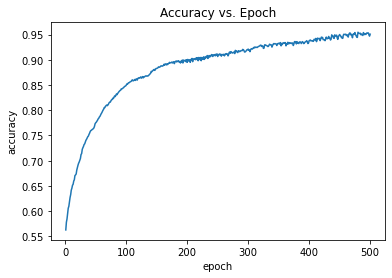

In [12]:
# clean error tracking data
error_tracking = pd.DataFrame()
error_tracking['epoch'] = range(1, 501)
error_tracking['accuracy'] = acc
error_tracking['mpe'] = mpe

# plot accuracy vs epoch
sns.lineplot(data=error_tracking, x='epoch', y='accuracy').set(title='Accuracy vs. Epoch')

In [13]:
# RUN model using 5 fold cross validation

# shuffle rows
df_art_features = df_art_features.sample(frac=1)

# 5 fold cross validation
kf = KFold(n_splits=5)

# fold accuracies
acc_lst = list()

# loop through each fold
for train_index, test_index in kf.split(df_art_features):
    
    # keep the x and y train data together, the perceptron data splits them up and does not use y as a feature
    Xy_train, Xy_test = df_art_features.iloc[list(train_index)], df_art_features.iloc[list(test_index)]

    # generate weights for model
    w, acc, mpe = perceptron(data=Xy_train, alpha=0.0001, epochs=500)
    
    # test model
    y_true = Xy_test['subreddit']
    y_pred = predict(Xy_test.iloc[:, 1:], w)
    
    scores = metrics(y_true, y_pred)
    fold_acc = scores['accuracy']
    acc_lst.append(fold_acc)
    print(fold_acc)
    
# mean of accuracies
avg_acc = np.mean(acc_lst)
    
print(f'Average Model Accuracy: {avg_acc}')

0.8525641025641025
0.8365384615384616
0.8461538461538461
0.8557692307692307
0.8782051282051282
Average Model Accuracy: 0.8538461538461538
